c:\Users\Alice\miniconda3\envs\qiskit0.46\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


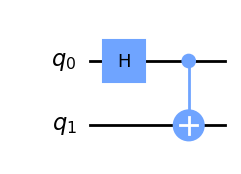

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

In [154]:
from qiskit import Aer, QuantumCircuit, transpile, execute
from qiskit.circuit import Parameter
import numpy as np
from scipy.optimize import minimize

In [155]:
####d=1 layer####
# Step 1: Define the QCBM circuit
def qcbm_circuit(params, num_qubits):
    qc = QuantumCircuit(num_qubits)
    # Apply parameterized rotations and entangling gates
    idx = 0
    for q in range(num_qubits):
        qc.rz(params[idx], q)
        qc.rx(params[idx+1], q)
        qc.rz(params[idx+2], q)
        idx += 3
    for q in range(num_qubits - 1):
        qc.cx(q, q + 1)
    return qc

In [156]:
# Step 2: Define the loss function
def loss_function(params, num_qubits, target_distribution):
    # Generate the QCBM circuit
    qc = qcbm_circuit(params, num_qubits)
    qc.measure_all()
    
    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    qc = transpile(qc, simulator)
    result = execute(qc, backend=simulator, shots=8000).result()
    counts = result.get_counts()
    
    # Convert counts to probabilities
    generated_distribution = {k: v / 8000 for k, v in counts.items()}
    
    # Calculate KL divergence (or another metric) between target and generated distributions
    kl_divergence = 0
    for bitstring, target_prob in target_distribution.items():
        generated_prob = generated_distribution.get(bitstring, 1e-10)
        kl_divergence += target_prob * np.log(target_prob / generated_prob)
    
    return kl_divergence

In [157]:
def gaussian_target_distribution(num_qubits):
    num_states = 2**num_qubits  # Total basis states
    mid_point = (num_states - 1) / 2  # Center the distribution
    
    # Map basis states to integers and calculate probabilities
    probabilities = []
    for i in range(num_states):
        x = i - mid_point  # Centered integer value
        prob = np.exp(-(x/4)**2 / 2)  # Gaussian probability
        probabilities.append(prob)
    
    # Normalize probabilities
    probabilities = np.array(probabilities)
    probabilities /= np.sum(probabilities)
    
    # Create target distribution as a dictionary
    target_distribution = {format(i, f'0{num_qubits}b'): prob for i, prob in enumerate(probabilities)}
    return target_distribution

In [158]:
# Step 3: Training the QCBM
num_qubits = 6
num_params = num_qubits * 3
initial_params = np.random.uniform(0, 2 * np.pi, num_params)

# Define target distribution (e.g., target state is |110⟩)
target_distribution = gaussian_target_distribution(num_qubits)

result = minimize(loss_function, initial_params, args=(num_qubits, target_distribution), method='COBYLA')
final_loss = result.fun
print(final_loss)

# Optimized parameters
optimized_params = result.x

0.09558849568375033


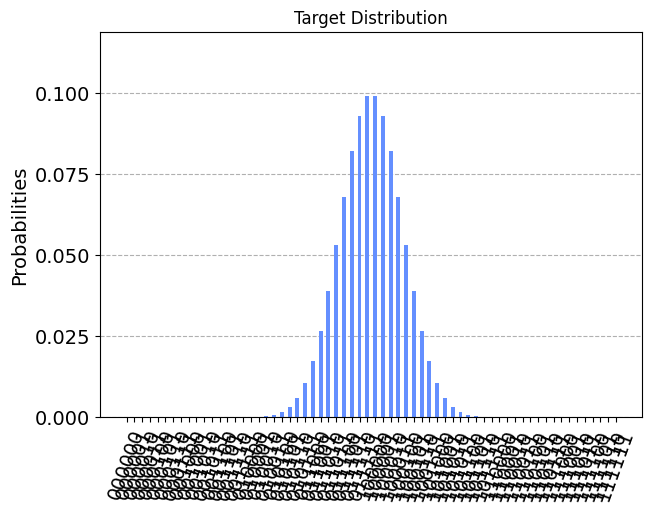

In [159]:
plot_histogram(target_distribution, title="Target Distribution", bar_labels=False)

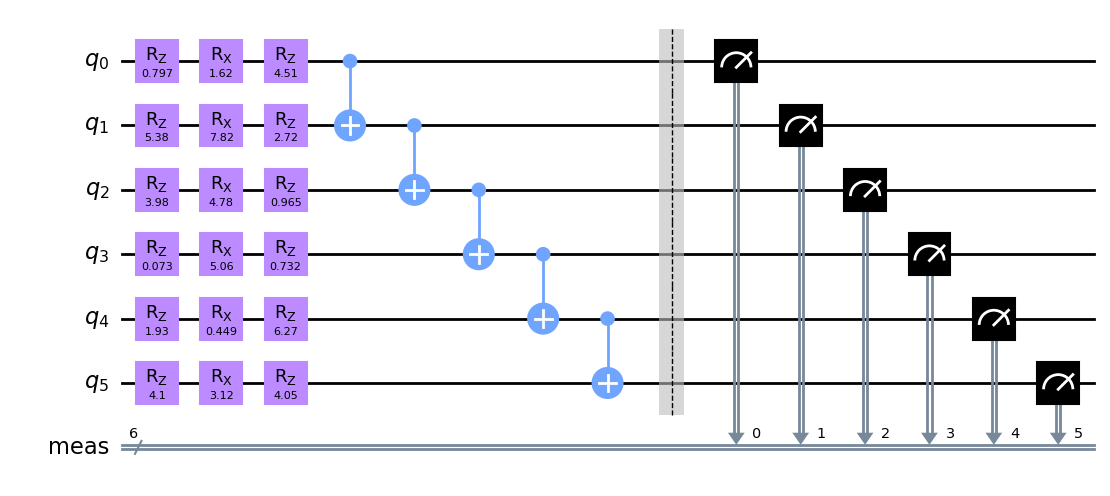

In [160]:
# Step 4: Generate samples using trained QCBM
trained_qcbm = qcbm_circuit(optimized_params, num_qubits)
trained_qcbm.measure_all()
trained_qcbm.draw(output="mpl")

In [161]:
simulator = Aer.get_backend('qasm_simulator')
trained_qcbm = transpile(trained_qcbm, simulator)
result = execute(trained_qcbm, backend=simulator, shots=8000).result()
counts = result.get_counts()

print("Generated Distribution:", counts)

Generated Distribution: {'010101': 14, '010100': 7, '101111': 35, '101000': 10, '101110': 34, '011111': 689, '101101': 37, '011011': 293, '010011': 36, '010010': 30, '000011': 1, '101001': 25, '101100': 33, '100111': 384, '010000': 34, '100001': 703, '011001': 324, '011101': 653, '100110': 311, '100000': 671, '011110': 616, '011000': 312, '100100': 279, '101010': 18, '010111': 21, '010110': 23, '100011': 644, '011100': 607, '011010': 245, '100010': 517, '101011': 8, '010001': 38, '100101': 348}


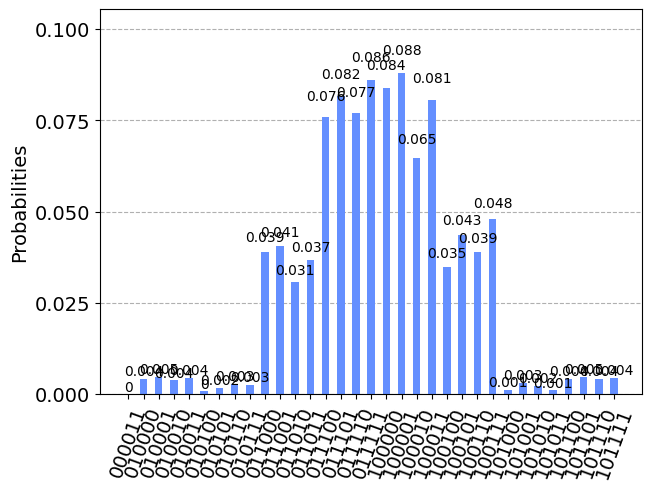

In [162]:
plot_histogram(counts)

In [163]:
###Gradient Descent###
from qiskit import Aer, QuantumCircuit, transpile, execute
from qiskit.circuit import Parameter
import numpy as np

def loss_function(params, num_qubits, target_distribution):
    qc = qcbm_circuit(params, num_qubits)
    qc.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    qc = transpile(qc, simulator)
    result = execute(qc, backend=simulator, shots=8000).result()
    counts = result.get_counts()

    # Normalize counts to probabilities
    generated_distribution = {k: v / 8000 for k, v in counts.items()}

    # Calculate KL divergence
    kl_divergence = 0
    for bitstring, target_prob in target_distribution.items():
        generated_prob = generated_distribution.get(bitstring, 1e-10)
        kl_divergence += target_prob * np.log(target_prob / generated_prob)

    return kl_divergence


In [164]:
def gradient_computer(params,params_shift,num_qubits, target_distribution):
    qc_a = qcbm_circuit(params, num_qubits)
    qc_a.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    qc_a = transpile(qc_a, simulator)
    result_a = execute(qc_a, backend=simulator, shots=8000).result()
    counts_a = result.get_counts()
    
    # Normalize counts to probabilities
    generated_distribution_a = {k: v / 8000 for k, v in counts_a.items()}
    
    qc_b = qcbm_circuit(params_shift, num_qubits)
    qc_b.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    qc_b = transpile(qc_b, simulator)
    result_b = execute(qc_b, backend=simulator, shots=8000).result()
    counts_b = result_b.get_counts()

    # Normalize counts to probabilities
    generated_distribution_b = {k: v / 8000 for k, v in counts_b.items()}
    
    gradient_component=0
    for bitstring, target_prob in target_distribution.items():
        generated_prob_a = generated_distribution_a.get(bitstring, 1e-10)
        generated_prob_b = generated_distribution_b.get(bitstring, 1e-10)
        gradient_component -=  target_prob /generated_prob_a*generated_prob_b
        
    return gradient_component

In [165]:
def compute_gradients(params, num_qubits, target_distribution):
    gradients = np.zeros_like(params)
    shift = np.pi / 2  # Parameter shift value

    for i in range(len(params)):
        # Shift parameter up
        params_shifted_up = np.copy(params)
        params_shifted_up[i] += shift
        loss_up = gradient_computer(params,params_shifted_up, num_qubits, target_distribution)

        # Shift parameter down
        params_shifted_down = np.copy(params)
        params_shifted_down[i] -= shift
        loss_down = gradient_computer(params, params_shifted_down, num_qubits, target_distribution)

        # Compute gradient
        gradients[i] = (loss_up - loss_down)

    return gradients


In [166]:
def gradient_descent(initial_params, num_qubits, target_distribution, learning_rate=0.1, max_iters=100):
    params = np.copy(initial_params)

    for iteration in range(max_iters):
        # Compute gradients
        gradients = compute_gradients(params, num_qubits, target_distribution)

        # Update parameters
        params -= learning_rate * gradients

        # Optional: Print progress
        loss = loss_function(params, num_qubits, target_distribution)
        print(f"Iteration {iteration + 1}: Loss = {loss}")

    return params

In [167]:
# Define parameters
num_qubits = 6
num_params = num_qubits * 3
initial_params = np.random.uniform(0, 2 * np.pi, num_params)

# Define target distribution
target_distribution = gaussian_target_distribution(num_qubits)

# Train using gradient descent
optimized_params = gradient_descent(
    initial_params, 
    num_qubits, 
    target_distribution, 
    learning_rate=0.1, 
    max_iters=100
    
)

print("Optimized Parameters:", optimized_params)


Iteration 1: Loss = 12.169225361741768
Iteration 2: Loss = 6.988933510825009
Iteration 3: Loss = 5.577037047251825
Iteration 4: Loss = 7.31094988054359
Iteration 5: Loss = 5.240514392733248
Iteration 6: Loss = 5.456328953349439
Iteration 7: Loss = 1.5821124704424632
Iteration 8: Loss = 10.844407701309096
Iteration 9: Loss = 10.127053634473238
Iteration 10: Loss = 8.844040951845235
Iteration 11: Loss = 11.292641982160351
Iteration 12: Loss = 8.47796673862722
Iteration 13: Loss = 15.225199059970967
Iteration 14: Loss = 7.77484864477767
Iteration 15: Loss = 12.487391290679044
Iteration 16: Loss = 8.548616075421439
Iteration 17: Loss = 5.384817655540508
Iteration 18: Loss = 14.563170931864244
Iteration 19: Loss = 12.239699790130356
Iteration 20: Loss = 11.412323450233616
Iteration 21: Loss = 10.275190860374991
Iteration 22: Loss = 13.92873866486152
Iteration 23: Loss = 6.9758573231055765
Iteration 24: Loss = 20.13621982168544
Iteration 25: Loss = 6.380905501651368
Iteration 26: Loss = 11.6

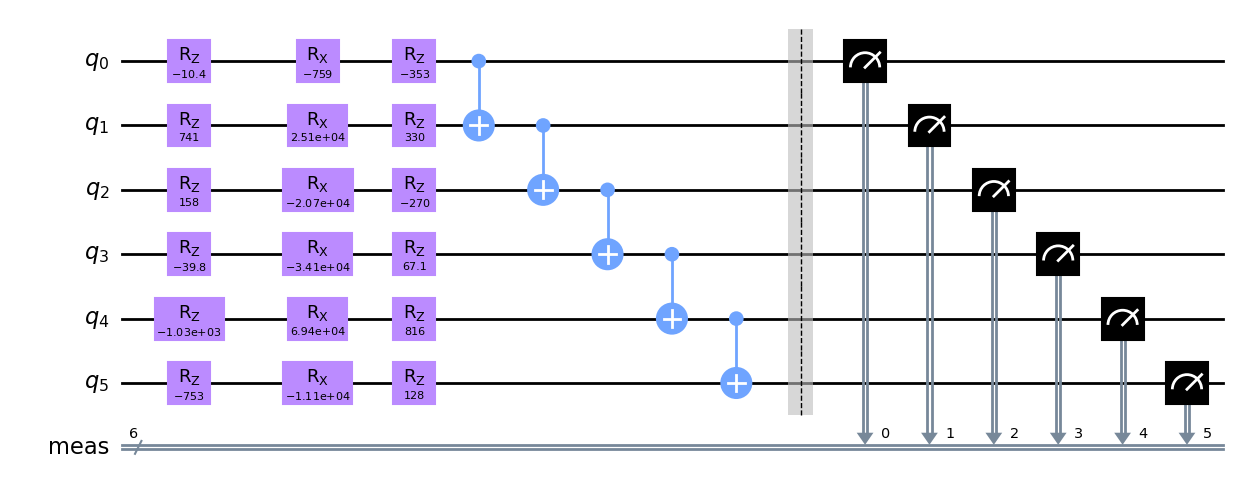

In [171]:
trained_qcbm_gd = qcbm_circuit(optimized_params, num_qubits)
trained_qcbm_gd.measure_all()
trained_qcbm_gd.draw(output="mpl")

In [172]:
result = execute(trained_qcbm, backend=simulator, shots=8000).result()
counts = result.get_counts()

print("Generated Distribution:", counts)

Generated Distribution: {'000010': 1, '101000': 22, '101010': 18, '101011': 14, '010001': 33, '010100': 14, '101110': 26, '010010': 39, '010011': 27, '101100': 36, '101001': 17, '101101': 30, '011011': 304, '010101': 19, '100110': 329, '101111': 35, '100111': 366, '011000': 342, '100100': 289, '100001': 670, '010000': 31, '011001': 320, '011101': 667, '011110': 617, '100000': 647, '100011': 629, '010110': 14, '011111': 702, '100010': 540, '100101': 326, '010111': 20, '011100': 588, '011010': 268}


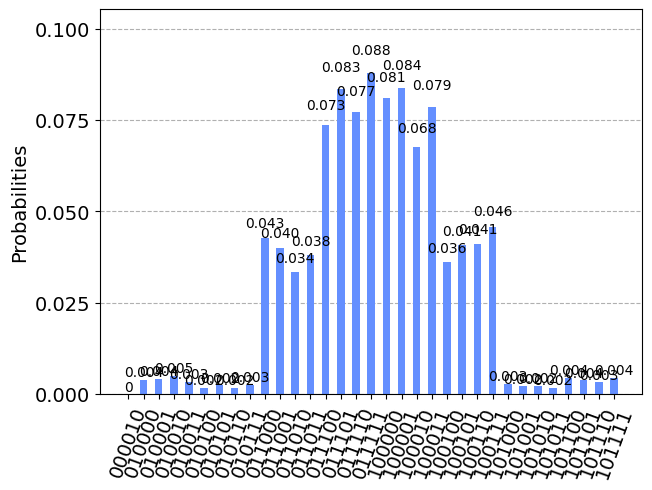

In [173]:
plot_histogram(counts)